# Spatial Feature Engineering

In machine learning and data science, we are often equipped with *tons* of data. Indeed, given the constellation of packages to query data services, free and open source data sets, and the rapid and persistent collection of geographical data, there is simply too much data to even represent coherently in a single, tidy fashion. However, we often need to be able to construct useful *features* from this rich and deep sea of data. 

Where data is available, but not yet directly *usable*, *feature engineering* helps to construct useful data for modelling a given phenomenon of interest. In traditional machine learning, feature engineering involves applying additional *domain knowledge* to raw information in order to structure it in a manner that is meaningful for a model. Often, this involves some sort of *transformation* of the original dataset, which is a well-studied concept in both classical statistics and remains so in machine learning methods. While *feature engineering* always relies on this implicit domain knowledge, it is an extremely important part of adapting general-purpose algorithms to unique or distinctive problems facing the every-day data scientist. 

Geography is one of the most high-quality, ubiquitous ways to introduce *domain knowledge* into a problem: everything has a position in both *space* and *time*. And, while things that happen near to one another *in time* do not necessarily have a fundamental relationship, things that are *near* one another are often related. Thus, space is the ultimate *linkage key*, allowing us to connect different datasets together in order to improve our models and our predictions. This means that, even for *aspatial*, "non-geographic" data, you can use *spatial feature engineering* to create useful, highly-relevant features for your analysis. 

At its core, *spatial feature engineering* is the process of developing additional information from raw data using *geographic knowledge*. This distilling of information can occur *between* datasets, where geography is used to link information in separate datasets together; or *within* datasets, where geography can be used to augment the information available for one sample by borrowing from nearby ones. This chapter is structured following that distinction: for cases where geography connects *different* datasets, we adopt the term "Map Matching", often used in industry; while we use the mirroring concept of "Map Synthesis" describing the use of geographical structure to derive new features from a given dataset. Technically speaking, some of the methods we review are similar across these two cases, or even the same; however they can be applied in the context of "matching" or "synthesis", and we consider those conceptually different, hence their inclusion in both sections. Throughout the chapter, we use the Airbnb nightly rental prices in San Diego, as well as auxilliary datasets such as elevation or Census demographics.

In [1]:
import geopandas, pandas, libpysal.weights as weights, contextily
from tobler.area_weighted import area_interpolate
import matplotlib.pyplot as plt
import cenpy
import numpy
import osmnx
import seaborn
import rasterio
from rasterio.plot import show as rioshow

Throughout this chapter, we will use a common dataset to which we want to append more information through geography. For the illustration, we will use the set of [AirBnb properties](../data/airbnb/regression_cleaning). Let's read it:

In [2]:
airbnbs = geopandas.read_file('../data/airbnb/regression_db.geojson')

## What is spatial feature engineering? 

At its core, *spatial feature engineering* is the process of developing additional information from raw data using *geographic knowledge*. This synthesis could occur *between* datasets, where geography is used to link samples in separate datasets together; or *within* datasets, where geography can be used to borrow information from nearby samples. Building linkages *between* datasets is often called "Map Matching", while we use the term "Map Synthesis" to describe the use of geographical structure to derive new features from existing data. Both kinds of geographic feature engineering will be covered in this chapter, starting first with various methods for Map Matching when modelling Airbnb nightly rental prices in San Diego.

To help us discuss this, a vocabulary is helpful. We will cover a few different kinds of features in this chapter, both of which can be constructed in either Map Synthesis or Map Matching operations: 
- A *spatial summary feature* measures the attributes of observations that have some pre-specified spatial relationship with our target observations. This includes 
    - taking the average or median value of features within a neighborhood of each target observation. 
    - the *spatial lag*, used in previous chapters of this book (e.g., Chapters 3, 6, and 11), is a kind of spatial summary feature, since it reflects the average value of the data in the neighborhood around each point. 
    - Other kinds of spatial summary features might include the count of observations within a given distance or the standard deviation of ten nearest observations. 
    - Summary features generally include *interpolated features* which involve a transfer of information from one spatial support to another, such as when the target locations are not the same as the locations in our anciliary data. Interpolated features become significantly more complex as well when the data is *areal*, as will be discussed later in this chapter.
- A *proximity feature* measures the distance from a target observation to some other observation or position in the map. This might be done in a map matching context, as we did before with the distance to Balboa Park, or it might be done in a map synthesis context by measuring the distance to the nearest other observation. 

## Feature Engineering Using Map Matching

Space is the ultimate linkage key; map matching is all about exploiting this asset. Geographic information is collected at different scales, aggregated using bespoke geographic delineations, and ultimately stored in different datasets. Modelling and machine learning usually require the use of data aligned and coherently structured; to bring disparate geo-datasets together, the data scientist needs to be able to transfer information expressed for one geography into another. This is where map matching comes to rescue. By using geographical location, we can connect datasets that have no common key or that are otherwise completely unrelated. This is a "magic trick" that we can pull off because of location that would be much harder, or impossible, with data lacking spatial information.

The details, and difficulty, of this transfer of information from one geography to another one depend on the nature of the "source" and "target", and on the precision with which we want to perform such transfer. In this context, there is always an inevitable trade-off between precission and sophistication: more precise transfer is usually possible at the expense of more advanced and involved techniques. Their additional cost in applying them, both in terms of cognitive load on the data scientist's part or in terms of computation, must be weighted in on an individual basis: sometimes we need the best possible estimates, at all costs; sometimes "good enough" is, well, good enough. 

In this section, we cover a few cases that we consider represent the most common and widely used approaches. We begin with situations where we have two point datasets and all we need to calculate are descriptive statistics of one dataset to the observations in the other. We swith the type of data and consider how to attach information from a continuous grid, stored in a raster file, to a set of points. Then we show the equivalent case for "moving" information for a polygon geography to a point dataset. These are all cases that, in their simplest form, involve mostly traditional GIS operations (e.g., buffer construction, spatial joins) and little in the way of statistical modelling. As an example of a case that is more involved, we cover the transfer of information from a polygon geography to another, different polygon geography. For this final case, but also as a more general comment, we try to include examples that capture the essence of the method, but keep the technique as simple as possible. For almost any of these cases we cover, the reader can find more sophisticated techniques that usually yield more accurate estimates. Where possible, we try to signpost these.

### Counting *nearby* features

A first, conceptually straightforward, approach is to augment our dataset by counting how many points of a different dataset are in the vicinity of each observation. For example, we might want to know how many bars and restaurants each AirBnb has within a given radius. This count can then become an additional  feature of our dataset, stored in a new column of `airbnbs`.

To obtain information on the location of restaurants and bars, we can download it from OpenStreetMap directly using `osmnx`. We first query all the points of interest (POIs) within the area our points cover, and then filter out everything except restaurants and bars. For that, we require  a polygon that covers all our `airbnbs` points. From Chapter 8, we can recall that there are a few different hulls that can be used. We'll use the Convex Hull here, which is the smallest convex polygon that covers all of the points in the set. 

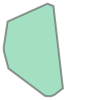

In [3]:
airbnbs_ch = airbnbs.unary_union.convex_hull
airbnbs_ch

Using this polygon, we can use the `osmnx` package to fetch points of interest (POIs) from OpenStreetMap. We can make our request more manageable by only requesting points of interest that fall within specific categories. Below, we'll request POIs within San Diego that are "restaurants" or "bars," according to their metadata stored in OpenStreetMap. (*note: this step requires internet connection as it is querying a remote server*):

In [4]:
%%time
pois = osmnx.pois_from_polygon(airbnbs_ch,
                               tags={"amenity": ['restaurant', 'bar']}
                              )

/opt/anaconda3/envs/analysis/lib/python3.8/site-packages/osmnx/pois.py:175: UserWarning: The `pois` module has been deprecated and will be removed in a future release. Use the `geometries` module's `geometries_from_polygon` function instead.
  warnings.warn(msg)


CPU times: user 464 ms, sys: 24 ms, total: 488 ms
Wall time: 5.31 s


This provides us with every location within our convex hull that is tagged as a "restaurant" or "bar" its metadata on OpenStreteMap. Overall, this provides us with about 1300 points of interest: 

In [5]:
pois.groupby('amenity').amenity.count()

amenity
bar            308
restaurant    1007
Name: amenity, dtype: int64

Once loaded into `pois` as a `GeoDataFrame`, let's take a peek at their location, as compared with AirBnb spots:

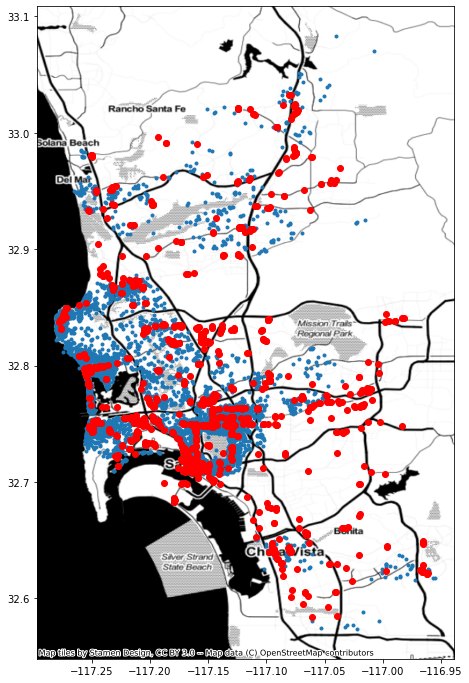

In [6]:
f,ax = plt.subplots(1,figsize=(12, 12))
airbnbs.plot(ax=ax, marker='.')
pois.plot(ax=ax, color='r')
contextily.add_basemap(ax, 
                       crs=airbnbs.crs.to_string(), 
                       source=contextily.providers.Stamen.Toner
                      )

Now, for some feature engineering, it may be extremely useful to know whether an Airbnb is located in a "hot" location, with a lot of restaurants and bars to choose from. Alternatively, if Airbnbs are very remote, they might not be as lucrative for short, expensive "city-break" reservations. That is, Airbnb users may decide to reserve stays where there are a lot of dining and drinking opportunities, and thus may be *willing to pay more* for the same accommodation. We might be able to predict prices better if we know about the drinking and dining scene near the Airbnb. 

Thus, we can *engineer features* in the Airbnb data using the nearby POIs. To do this, we can create a new feature for the AirBnb dataset --that is, a new column in `airbnbs`-- which incorporates information about how many POIs are *nearby* each property. This kind of "feature counting" is useful in applications where the mere presence of nearby features can affect the quantity we are modelling. 

To do this kind of feature engineering, let us first walk through what we need to do at a conceptual level: 

1. Decide what is *nearby*. This will dictate how far we go from each AirBnb when counting the number of "nearby" bars & restaurants. For this example, we will use 500 meter buffer, which is approximately the distance of a leisurely ten-minute walk.
2. For each AirBnb, determine whether POIs are *within* a leisurely 10-minute walk. 
3. Count how many POIs are withing the specified radius of each AirBnb.

At the end of this procedure, we have the number of bars & restuarants that are within a leisurely walk of the AirBnb, which might be useful in predicting the price of each AirBnb. 

With this, let us now translate the list above into code. For part 1., we need to be able to measure distances in metres. However, `airbnbs` is originally expressed in degrees, since it is provided in terms of locations in latitude and longitude:

In [7]:
airbnbs.crs

<Geographic 2D CRS: EPSG:4326>
Name: WGS 84
Axis Info [ellipsoidal]:
- Lat[north]: Geodetic latitude (degree)
- Lon[east]: Geodetic longitude (degree)
Area of Use:
- name: World
- bounds: (-180.0, -90.0, 180.0, 90.0)
Datum: World Geodetic System 1984
- Ellipsoid: WGS 84
- Prime Meridian: Greenwich

In addition, the `pois` are also provided in terms of their latitude & longitude:

In [8]:
pois.crs

<Geographic 2D CRS: EPSG:4326>
Name: WGS 84
Axis Info [ellipsoidal]:
- Lat[north]: Geodetic latitude (degree)
- Lon[east]: Geodetic longitude (degree)
Area of Use:
- name: World
- bounds: (-180.0, -90.0, 180.0, 90.0)
Datum: World Geodetic System 1984
- Ellipsoid: WGS 84
- Prime Meridian: Greenwich

Therefore, we need to convert this into a coordinate system that is easier to work with. Here, we will use a projection common for mapping in California, the California Albers projection:

In [9]:
airbnbs_albers = airbnbs.to_crs(epsg=3311)
pois_albers = pois.to_crs(epsg=3311)

In [10]:
pois_albers.crs

<Projected CRS: EPSG:3311>
Name: NAD83(HARN) / California Albers
Axis Info [cartesian]:
- X[east]: Easting (metre)
- Y[north]: Northing (metre)
Area of Use:
- name: USA - California
- bounds: (-124.45, 32.53, -114.12, 42.01)
Coordinate Operation:
- name: California Albers
- method: Albers Equal Area
Datum: NAD83 (High Accuracy Reference Network)
- Ellipsoid: GRS 1980
- Prime Meridian: Greenwich

With this, we can create the radius of 500m around each AirBnb. This is often called *buffering*, where a shape is dilated by a given radius.

In [11]:
airbnbs_albers['buffer_500m'] = airbnbs_albers.buffer(500)

Now, `abb_buffer` contains a 500-meter circle around each Airbnb.

Using these, we can count the number of POIs that are within these areas using a *spatial join*. Spatial joins link geometries based on spatial relationships (or predicates). Here, we need to know the relationship: `pois within airbnb_buffers`, where `within` is the predicate relating `pois` to `airbnb_buffers`. Predicates are not always *reversible*: no `airbnb_buffer` can be `within` a `poi`. In `geopandas`, we can compute all pairs of relations between the `pois` and `airbnb_buffers` efficiently using the `sjoin` function, which takes a `predicate` argument defining the requested relationship between the first & second argument. 

In [12]:
joined = geopandas.sjoin(pois_albers,
                    airbnbs_albers.set_geometry('buffer_500m')[['id', 'buffer_500m']],
                    op="within"
                   )

The resulting joined object `joined` contains a row for every pair of POI and AirBnb that are linked. From there, we can apply a group-by operation, using the AirBnb ID, and count how many POIs each AirBnb has within 500m of distance:

In [13]:
poi_count = joined.groupby("id")\
                  ["osmid"]\
                  .count()\
                  .to_frame('poi_count')
poi_count.head()

,poi_count
id,
6,12
5570,7
9553,12
38245,1
69385,8


The resulting `Series` is indexed on the AirBnb IDs, so we can assign it to the original `airbnbs` table. In this case, we know by construction that missing AirBnbs in `poi_count` do not have any POI within 500m, so we can fill missing values in the column with zeros.

In [14]:
airbnbs_w_counts = airbnbs_albers.merge(poi_count, left_on='id', right_index=True)\
                                 .fillna({"poi_count": 0})

We can visualise now the distribution of counts to get a sense of how "well-served" AirBnb properties are arranged over space (for good measure, we'll also add a legendgram):

<frozen importlib._bootstrap>:219: RuntimeWarning: numpy.ufunc size changed, may indicate binary incompatibility. Expected 192 from C header, got 216 from PyObject


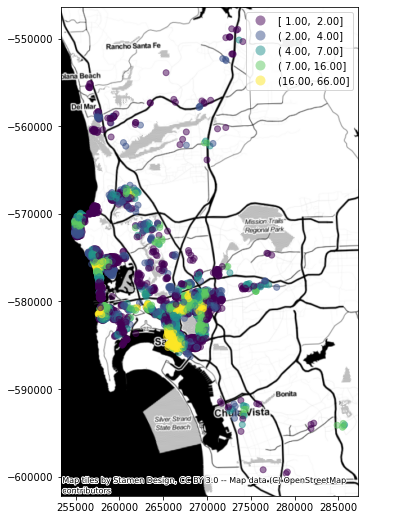

In [15]:
f, ax = plt.subplots(1, figsize=(9, 9))
airbnbs_w_counts.plot(column="poi_count",
                      scheme="quantiles",
                      alpha=0.5,
                      legend=True,
                      ax=ax
                     )
contextily.add_basemap(ax, 
                       crs=airbnbs_albers.crs.to_string(), 
                       source=contextily.providers.Stamen.Toner
                      )

---

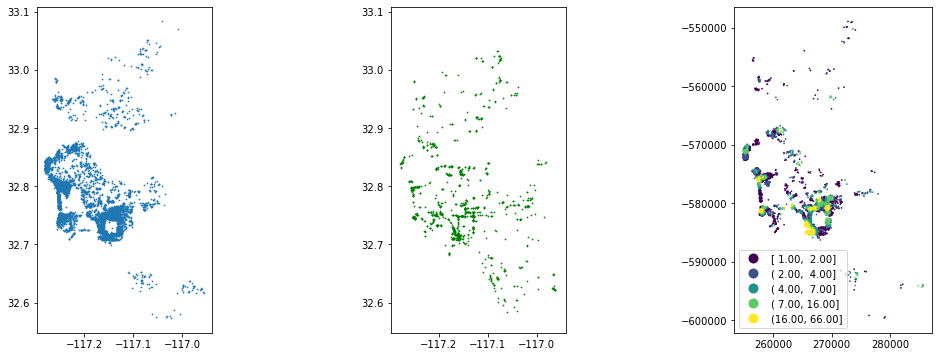

In [16]:
f, axs = plt.subplots(1, 3, figsize=(18, 6))

airbnbs.plot(ax=axs[0], markersize=0.5)

pois.plot(ax=axs[1], color="green", markersize=0.5)

airbnbs_w_counts.plot(column="poi_count",
                      scheme="quantiles",
                      markersize=0.5,
                      legend=True,
                      ax=axs[2]
                     )

axs[1].set_xlim(axs[0].get_xlim())
axs[1].set_ylim(axs[0].get_ylim())

plt.show()

### Assigning point values from surfaces: elevation of AirBnbs

We have just seen how to count points around each observation in a point dataset. In other cases, we might be confronted with a related but different challenge: transfering the value of a particular point in a surface to a point in a different dataset. 

To make this more accessible, let us illustrate the context with an example question: *what is the elevation of each AirBnb property?* To answer this question, we require, at least, the following:

1. A sample of AirBnb property locations.
1. A dataset of elevation. We will use here the [NASA DEM](../data/nasadem/README.md) surface for the San Diego area.

Let us bring the elevation surface:

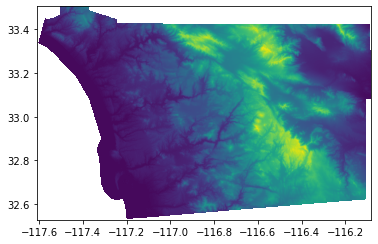

In [17]:
dem = rasterio.open("../data/nasadem/nasadem_sd.tif")
rioshow(dem)

Let's first check the CRS is aligned with our sample of point locations:

In [18]:
dem.crs

CRS.from_epsg(4326)

We have opened the file with `rasterio`, which has not read the entire dataset just yet. This feature allows us to use this approach with files that are potentially very large, as only requested data is read into memory.

To extract a discrete set of values from the elevation surface in `dem`, we can use `sample`. For a single location, this is how it works:

In [19]:
list(dem.sample([(-117.24592208862305, 32.761619109301606)]))

[array([7], dtype=int16)]

Now, we can  apply this logic to a sequence of coordinates. For that, we need to extract them from the `geometry` object:

In [20]:
abb_xys = pandas.DataFrame({"X": airbnbs.geometry.x, 
                            "Y": airbnbs.geometry.y
                           }).to_records(index=False)

In [21]:
elevation = pandas.DataFrame(dem.sample(abb_xys),
                             columns=["Elevation"],
                             index=airbnbs.index
                            )
elevation.head()

,Elevation
0,112
1,3
2,99
3,114
4,30


Now we have a table with the elevation of each  AirBnb property, we can plot the site elevations on a map for visual inspection:

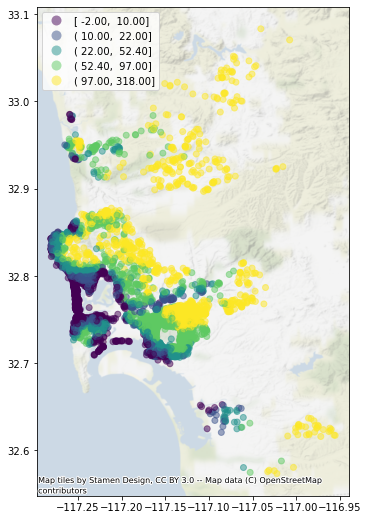

In [22]:
f, ax = plt.subplots(1, figsize=(9, 9))
airbnbs.join(elevation)\
       .plot(column="Elevation",
             scheme="quantiles",
             legend=True,
             alpha=0.5,
             ax=ax
            )
contextily.add_basemap(ax, 
                       crs=airbnbs.crs.to_string(), 
                       source=contextily.providers.Stamen.TerrainBackground,
                       alpha=0.5
                      )

---

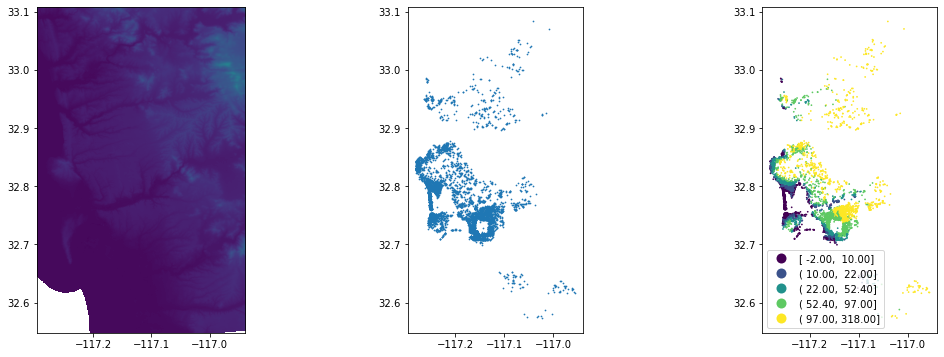

In [23]:
f, axs = plt.subplots(1, 3, figsize=(18, 6))

rioshow(dem, ax=axs[0])

airbnbs.plot(ax=axs[1], markersize=0.5)

airbnbs.join(elevation)\
       .plot(column="Elevation",
             scheme="quantiles",
             markersize=0.5,
             legend=True,
             ax=axs[2]
            )

axs[0].set_xlim(axs[1].get_xlim())
axs[0].set_ylim(axs[1].get_ylim())

plt.show()

### Point Interpolation using sklearn 

In the previous example, we have transfered information from a surface (stored in a raster layer) to a set of points; in other words, we have gone from surface to points. Sometimes, however, we do not have the luxury of a ready-made surface. Instead, all we have available is a set of points with measurements for the variable of interest that do not match the points we want the information for. In this situation, a solution we can rely on is "spatial interpolation". For a continuous geographical field measured at a set of points, "spatial interpolation" methods provide us a way to guess at at the value a field would take at sites we do not measure. 

There are many sophisticated methods with which this can be done. *Kriging*, common in the sub-field of spatial statistics called "geostatistics," is one such practice based on the theory of *Gaussian Process Regression.* Another common approach, *geographically-weighted regression*, provides unique model estimates at every control point, as well as predictions for places where there is no data. Here, though, we'll use a very basic $k$-nearest neighbor prediction algorithm from `scikit-learn` to demonstrate the process. This process will select the nearest 10 listings, then compute the prediction using a weighted average of these nearest observations. To keep predictions relatively consistent, we will build an interpolation only for listings that are entire homes/apartments with two bedrooms:

In [24]:
from sklearn.neighbors import KNeighborsRegressor

In [28]:
two_bed_homes = airbnbs[airbnbs['bedrooms']==2 & airbnbs['rt_Entire_home/apt']]

In [29]:
two_bed_home_locations = numpy.column_stack((two_bed_homes.geometry.x, 
                                             two_bed_homes.geometry.y))

To plot the interpolated surface, we must also construct a grid of locations for which we will make predictions. This can be done using `numpy.meshgrid`, which constructs all the combinations of the input dimensions as a grid of outputs. 

In [30]:
xmin, ymin, xmax, ymax = airbnbs.total_bounds
x, y = numpy.meshgrid(numpy.linspace(xmin, xmax), 
                      numpy.linspace(ymin,ymax))

Text(0.5, 1.0, 'Y values')

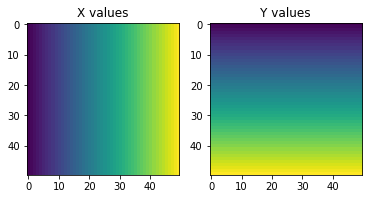

In [31]:
f,ax = plt.subplots(1,2)
ax[0].imshow(x)
ax[1].imshow(y)
ax[0].set_title('X values')
ax[1].set_title('Y values')

With these coordinates, we can make a geodataframe containing the grid cells at which we would like to predict:

In [32]:
grid = numpy.column_stack((x.flatten(), y.flatten()))
grid_df = geopandas.GeoDataFrame(geometry=geopandas.points_from_xy(x=x.flatten(), 
                                                                   y=y.flatten()))

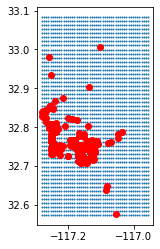

In [33]:
ax = grid_df.plot(markersize=1)
two_bed_homes.plot(ax=ax, color='red')

With this done, we can now construct the predictions. First we train the model:

In [34]:
model = KNeighborsRegressor(n_neighbors=10, weights='distance').fit(two_bed_home_locations, two_bed_homes.price)

And then we predict at the grid cells:

In [35]:
predictions = model.predict(grid)

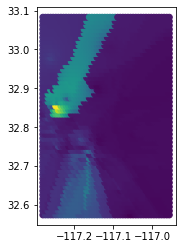

In [36]:
grid_df.plot(predictions)

You can see that the surface gets smoother as you increase the number of nearest neighbors to consider:

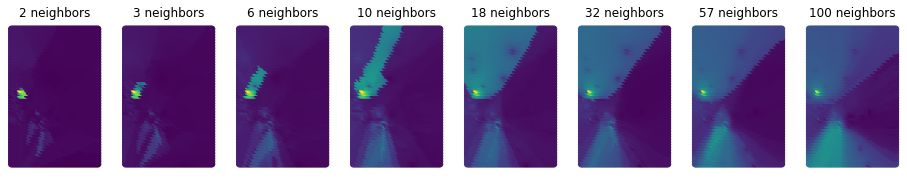

In [37]:
f,ax = plt.subplots(1,8, figsize=(16,4))
for i,k_neighbors in enumerate(numpy.geomspace(2, 100, 8).astype(int)):
    facet = ax[i]
    predictions = KNeighborsRegressor(n_neighbors=k_neighbors, weights='distance')\
                          .fit(two_bed_home_locations, two_bed_homes.price)\
                          .predict(grid)
    grid_df.plot(predictions, ax=facet)
    facet.axis('off')
    facet.set_title(f"{k_neighbors} neighbors")

Focusing in on central San Diego tells the story a bit more clearly, since there are more points there to show. The increasing number of nearest neighbors increases the smoothness of the interpolated surface. 

In [38]:
central_sd_bounds = [-117.179832, 32.655563, -117.020874, 32.769909]
central_xmin, central_ymin, central_xmax, central_ymax = central_sd_bounds

In [39]:
central_x, central_y = numpy.meshgrid(numpy.linspace(central_xmin, central_xmax), 
                                      numpy.linspace(central_ymin, central_ymax))
central_grid = numpy.column_stack((central_x.flatten(), central_y.flatten()))
central_grid_df = geopandas.GeoDataFrame(geometry=geopandas.points_from_xy(x=central_x.flatten(), 
                                                                           y=central_y.flatten()))

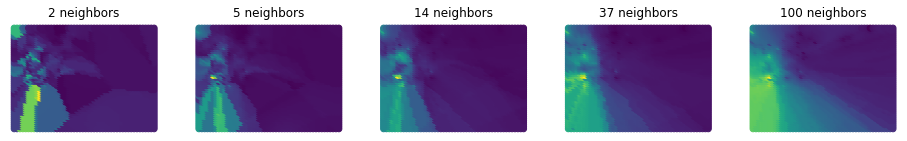

In [40]:
f,ax = plt.subplots(1,5, figsize=(16,4), sharex=True, sharey=True)

for i,k_neighbors in enumerate(numpy.geomspace(2, 100, 5).astype(int)):
    facet = ax[i]
    predictions = KNeighborsRegressor(n_neighbors=k_neighbors, weights='distance')\
                          .fit(two_bed_home_locations, two_bed_homes.price)\
                          .predict(central_grid)
    central_grid_df.plot(predictions, ax=facet)
    facet.axis('off')
    facet.set_title(f"{k_neighbors} neighbors")

Plenty more of these methods are implemented in `scikit-learn.neighbors`, as well as kriging methods in `GSTools` and geographically-weighted regression in `mgwr`. 

### Polygon to point

We now move on to a case where the information we are interested in matching to our set of points is stored for a polygon geography. For example, we would like to know the population density of the neighborhood in which each AirBnb is located. To determine density, we will download population estimates at the Census tract level, and "transfer" those estimates over to each AirBnb point. Geographically, the only challenge here is finding the containing polygon for each point, and then performing what is in spatial databases parlance known as a "spatial join", by which we link the two layers through their spatial connection.

Let us pull down the number of inhabitants from the American Community Survey for tracts in San Diego:

In [41]:
%%time
acs = cenpy.products.ACS()
sd_pop = acs.from_msa("San Diego, CA",
                      level = "tract",
                      variables=['B02001_001E']
                     )

/opt/anaconda3/envs/analysis/lib/python3.8/site-packages/pyproj/crs/crs.py:55: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  return _prepare_from_string(" ".join(pjargs))


CPU times: user 2.97 s, sys: 129 ms, total: 3.1 s
Wall time: 20.2 s


And calculate population density:

In [42]:
sd_pop["density"] = sd_pop["B02001_001E"] / sd_pop.to_crs(epsg=3311).area

Now, to "transfer" density estimates to each AirBnb, we can rely on the spatial join in `geopandas`:

In [43]:
j = geopandas.sjoin(airbnbs, sd_pop.to_crs(airbnbs.crs))

The result is a table with one row per AirBnb and one column for each attribute we originally had for properties, *as well as* those of the tract where the area is located:

In [44]:
j.info()

<class 'geopandas.geodataframe.GeoDataFrame'>
Int64Index: 6110 entries, 0 to 6068
Data columns (total 28 columns):
 #   Column              Non-Null Count  Dtype   
---  ------              --------------  -----   
 0   accommodates        6110 non-null   int64   
 1   bathrooms           6110 non-null   float64 
 2   bedrooms            6110 non-null   float64 
 3   beds                6110 non-null   float64 
 4   neighborhood        6110 non-null   object  
 5   pool                6110 non-null   int64   
 6   d2balboa            6110 non-null   float64 
 7   coastal             6110 non-null   int64   
 8   price               6110 non-null   float64 
 9   log_price           6110 non-null   float64 
 10  id                  6110 non-null   int64   
 11  pg_Apartment        6110 non-null   int64   
 12  pg_Condominium      6110 non-null   int64   
 13  pg_House            6110 non-null   int64   
 14  pg_Other            6110 non-null   int64   
 15  pg_Townhouse        6110 non-n

---

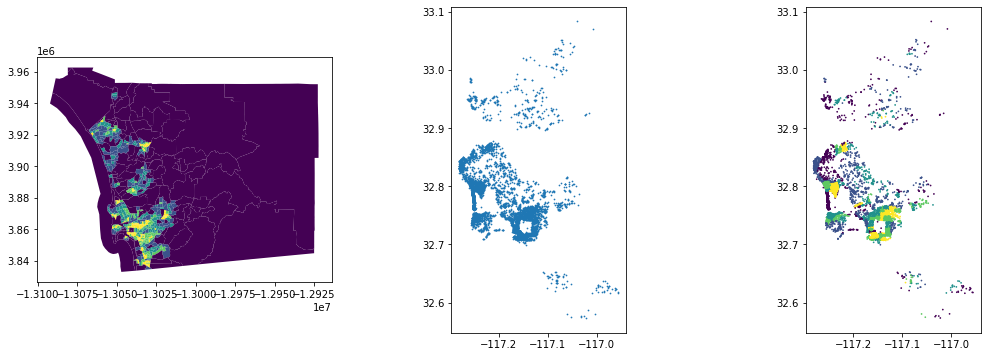

In [45]:
f, axs = plt.subplots(1, 3, figsize=(18, 6))

sd_pop.plot(column="density", scheme="quantiles", ax=axs[0])

airbnbs.plot(ax=axs[1], markersize=0.5)

j.plot(column="density",
       scheme="quantiles",
       markersize=0.5,
       ax=axs[2]
      )

plt.show()

### Area to area interpolation

The final case of map matching we consider is transfer of information from one polygon/areal geography to a different one. This is a common use-case when an analysis requires data that is provided at different levels of aggregation and different boundary delineations.

There is a large literature around this problem under the umbrella of dasymetric mapping {cite}`eicher2001dasymetric`. The conceptual idea is relatively straight-forward: we want to apportion values from one set of polygons to the other based on how much "geography" is shared. In its simplest case, we can do this based on area. In this case, we will assign values from the source geography to the target based on how much they share. Let us illustrate this with an example. We will call the geography for which we have data the "source", and that to which we want to transfer data the "target". If polygon A in the target is made up of 50% of polygon 1 in the source, 30% of polygon 2, and 20% of polygon 3, the estimate for A will be a weighted average between the values in 1, 2, and 3, where the weights are 0.5, 0.3, and 0.2, respectively. Of course, underlying this exercise is the implicit assumption that the values we are interested in are uniformly distributed within each polygon in the source and target. In some cases, this is a valid assumption or, at least, it does not introduce critical errors; in others, this is not acceptable. Dasymetric mapping has proposed a large amount of sophistications that try to come up with more realistic estimates and that can incorporate additional information.

To implement dasymetric mapping in Python, the best option is `tobler`, a package from the PySAL federation designed exactly for this goal. We will show here the simplest case, that of areal interpolation where apportioning is estimated based on area, but the package also provides more sophisticated approaches.

For the example, we need two polygon layers. We will stick with San Diego and use the set of Census Tracts and the [H3 hexagonal grid layer](../data/h3_grid/README.md). Our goal will be to create population estimates for each hexagon.

First, let us load the H3 grid:

In [46]:
h3 = geopandas.read_file("../data/h3_grid/sd_h3_grid.gpkg")

We are ready to interpolate:

In [47]:
interpolated = area_interpolate(source_df=sd_pop.to_crs(epsg=3311),
                                target_df=h3.to_crs(epsg=3311),
                                extensive_variables=["B02001_001E"],
                                intensive_variables=["density"]
                               )

There is quite a bit going on in the cell above, let us unpack it:

- Remember this method apportions data values based on area, so it makes sense to have an accurate estimate for the extent of each polygon. To do that, we convert each geography to Albers Equal (`EPSG:3311`), which is expressed in metres, using `to_crs`.
- The method `area_interpolate` then takes the source and the target `GeoDataFrame` objects using the same naming convention we have in our explanation. 
- In addition, we need to specify which variables we would like to interpolate. here, Tobler makes a distinction:
    - *Extensive* variables, or absolute values such as counts, aggregates, etc. (which we use for population, `B02001_001E`)
    - *Intensive* variables, such as rates, ratios, etc. (which we select for density as it is the ratio of population over area)

A good first approach to examine the output is by comparing the source and the target visually. Here is total population:

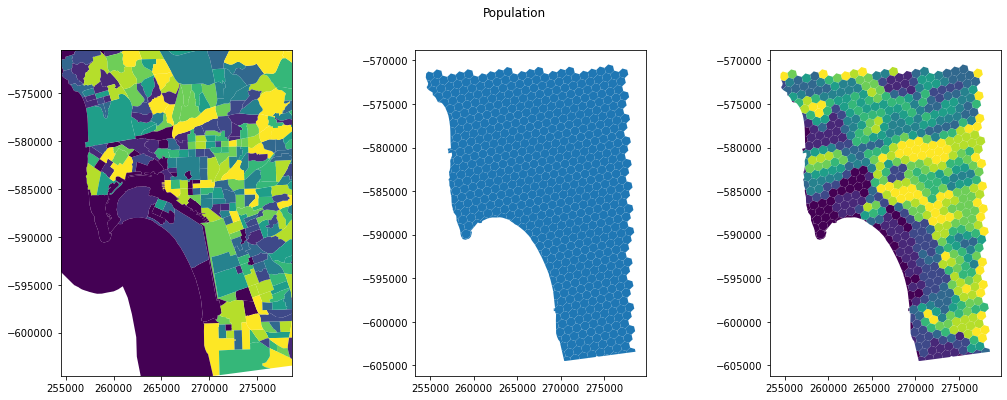

In [48]:
f, axs = plt.subplots(1, 3, figsize=(18, 6))

minX, minY, maxX, maxY = interpolated.total_bounds
sd_pop.to_crs(epsg=3311)\
      .cx[minX:maxX, minY:maxY]\
      .plot(column="B02001_001E", 
            scheme="quantiles", 
            k=10,
            ax=axs[0]
           )

h3.to_crs(epsg=3311)\
  .plot(ax=axs[1], markersize=0.5)

interpolated.plot(column="B02001_001E",
                  scheme="quantiles",
                  k=10,
                  ax=axs[2]
                 )

axs[0].set_xlim(minX, maxX)
axs[0].set_ylim(minY, maxY)

f.suptitle("Population")

plt.show()

And density:

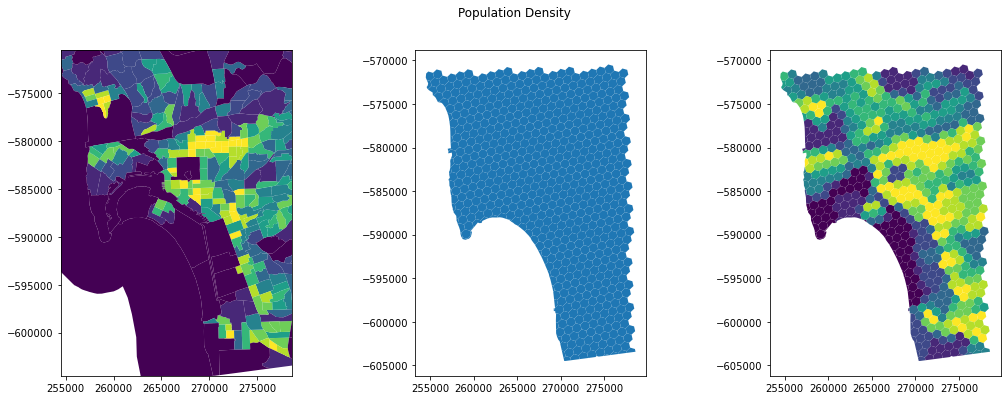

In [49]:
f, axs = plt.subplots(1, 3, figsize=(18, 6))

minX, minY, maxX, maxY = interpolated.total_bounds
sd_pop.to_crs(epsg=3311)\
      .cx[minX:maxX, minY:maxY]\
      .plot(column="density", 
            scheme="quantiles", 
            k=10,
            ax=axs[0]
           )

h3.to_crs(epsg=3311)\
  .plot(ax=axs[1], markersize=0.5)

interpolated.plot(column="density",
                  scheme="quantiles",
                  k=10,
                  ax=axs[2]
                 )

axs[0].set_xlim(minX, maxX)
axs[0].set_ylim(minY, maxY)

f.suptitle("Population Density")

plt.show()

## Feature Engineering using Map Synthesis

Feature engineering with map matching is most helpful when you have additional information to use in the analysis. And, with the wealth of freely available data from censuses, satellites, and open volunteered geographic information vendors such as OpenStreetMap, map matching can be a very powerful tool for enriching and improving your analyses. However, it is sometimes *also* useful to only examine the data you've got, and use the spatial structure within to build better features or better models. While this might be done using spatially-explicit models (like those covered in Chapter 11), it is also possible to use map synthesis to build spatial feature and improve your predictions.

There is an extensive amount of map synthesis features. In addition to the two kinds of features discussed in map matching, there are other kinds of useful features that can be used in map synthesis that will be discussed below. First, we will return to spatial summary features. Second, we will examine some *regionalization features*, which detect and leverage geographical clusters in the data to improve prediction. 

### Spatial Summary Features in Map Synthesis

Just like in map matching, you can use spatial summary features in map synthesis to make better predictions. One clear method involves constructing spatial summary measures of your training data. This is done in the same manner as in map matching, except we can now refer only to the data on hand. Thus, we may want to determine whether nearby Airbnbs are "competing" with each Airbnb. We might do this by finding the distance to the nearest Airbnb with the same number of bedrooms, since two nearby listings that *also* sleep the same number of people likely will compete with one another for tenants. 

#### Distance buffers within a single table

We might do this by building a `DistanceBand` weight object, which considers Airbnb as "neighbors" if they are within the distance threshold. 

In [50]:
d500_w = weights.DistanceBand.from_dataframe(airbnbs_albers, threshold=500, silence_warnings=True)

Now, we can get the average size of surrounding Airbnbs directly as the spatial lag:

In [51]:
d500_w.transform = 'r'

In [52]:
local_average_bedrooms = weights.lag_spatial(d500_w, airbnbs_albers[['bedrooms']].values)

While related, these features contain quite distinct pieces of information, and both may prove useful in modelling: 

Text(0, 0.5, "Average of nearby\n listings' bedrooms")

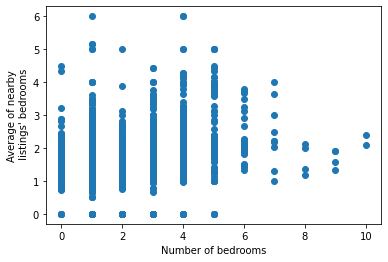

In [53]:
plt.scatter(airbnbs_albers[['bedrooms']].values, local_average_bedrooms)
plt.xlabel("Number of bedrooms")
plt.ylabel("Average of nearby\n listings' bedrooms")

If we were instead interested in the most common number of bedrooms, rather than the average, we could use the `lag_categorical` function:

In [54]:
local_mode = weights.lag_categorical(d500_w, airbnbs_albers[['bedrooms']].values)

/opt/anaconda3/envs/analysis/lib/python3.8/site-packages/numpy/core/fromnumeric.py:3334: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/opt/anaconda3/envs/analysis/lib/python3.8/site-packages/numpy/core/_methods.py:161: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Since we are now treating the number of bedrooms as a discrete feature, we can use a crosstab from `pandas` to examine the relationship between a listing and the typical size of listings nearby:

In [55]:
crosstab = pandas.crosstab(airbnbs_albers.bedrooms, 
                           local_mode.flatten())
crosstab.columns.name = "nearby"
crosstab

nearby,0.0,1.0,2.0,3.0,4.0,5.0,6.0,7.0
bedrooms,,,,,,,,
0.0,4,391,40,8,2,0,0,0
1.0,2,3066,213,33,19,5,0,0
2.0,2,978,267,12,3,1,0,0
3.0,2,427,165,37,11,2,0,0
4.0,0,170,55,10,30,6,2,0
5.0,0,51,17,2,9,19,0,0
6.0,0,14,9,1,4,1,0,0
7.0,0,5,1,2,1,0,0,1
8.0,0,3,1,0,0,0,0,0


If more complicated statistics are required. it can help to re-express the construction of summary statistics as a *reduction* of the *adjacency list* representation of our weights, as done in Chapter 3. To recap, the *adjacency list* is a `pandas.DataFrame` where each row contains a single link in our graph. It contains the identifier for some `focal` observation, the identifier for some `neighbor` observation, and a value for the `weight` of the link that connects the `focal` and `neighbor`:

In [56]:
adjlist = d500_w.to_adjlist()

In [57]:
adjlist.head()

,focal,neighbor,weight
0,0,136,0.023256
1,0,279,0.023256
2,0,317,0.023256
3,0,616,0.023256
4,0,761,0.023256


If we had the values for each for the neighbors in this adjacency list table, then we could use a `groupby()` to summarize the values of observations connected to a given focal observation. This merge can be done directly with the original data, linking the `neighbor` key in the adjacency list back to that observation in our source table: 

In [58]:
adjlist = adjlist.merge(airbnbs_albers[['bedrooms']], left_on='neighbor', 
                        right_index=True, how='left')
adjlist.head()

,focal,neighbor,weight,bedrooms
0,0,136,0.023256,1.0
1,0,279,0.023256,3.0
2,0,317,0.023256,2.0
3,0,616,0.023256,1.0
4,0,761,0.023256,1.0


Now, we need only to group the adjacency list by the focal observation and summarize the `bedrooms` column to obtain the median number of bedrooms for each `focal` observation. 

In [59]:
adjlist.groupby("focal").bedrooms.median()

focal
0       1.0
1       2.0
2       1.0
4       1.0
5       1.0
       ... 
6105    1.0
6106    1.0
6107    1.0
6108    1.0
6109    1.0
Name: bedrooms, Length: 6035, dtype: float64

Since the mean and/or mode are the most commonly-used measures of central tendency, the `lag_spatial` and `lag_categorical` functions cover many of the required uses in practice. 

#### "Ring" buffer features

Sometimes, analysts might want to use multiple "bands" of buffer features. This requires that we build summaries of the observations that fall *only within* a given range of distances, such as the typical size of houses that are further than 500m, but still within 1km. This kind of "ring buffer", or annulus, is a common request in spatial analysis, and can be done in substantially the same way as before by increasing the `threshold` in a `DistanceBand` weight.  

So, we can use our 500m weights from before to build the average again:

In [60]:
average_within_500 = weights.lag_spatial(d500_w, airbnbs_albers[['bedrooms']].values)

Then, we need to build the graph of airbnbs that fall *between* 500m and 1km from one another. To start, we build the `DistanceBand` graph of all listings closer than 1km:

In [61]:
d1k_w = weights.DistanceBand.from_dataframe(airbnbs_albers, threshold=1000, silence_warnings=True)

Then, using the `weights.set_operations` module, we can express set-theoretic relationships between graphs. Here, we need to *remove* the links in our 1km graph that are *also* links in the 500m graph. To do this, we need `w_difference(d1k_w, d500_w)`, the difference between the 1km graph and the 500m graph: 

In [62]:
d1k_exclusive = weights.set_operations.w_difference(d1k_w, d500_w, constrained=False)

/opt/anaconda3/envs/analysis/lib/python3.8/site-packages/libpysal/weights/weights.py:172: UserWarning: The weights matrix is not fully connected: 
 There are 60 disconnected components.
 There are 32 islands with ids: 762, 907, 976, 1003, 1776, 1867, 2789, 2841, 3130, 3138, 3184, 3604, 3748, 3962, 3989, 4366, 4443, 4627, 4764, 4885, 4989, 5014, 5536, 5733, 5756, 5790, 5796, 5808, 6005, 6026, 6049, 6068.
  warnings.warn(message)


Then, we can compute the average size of listings between 500m and 1km in the same manner as before using our `d1k_exclusive` graph, which now omits all edges shorter than 500m. 

In [63]:
d1k_exclusive.transform= 'r'
average_500m_to_1k = weights.lag_spatial(d1k_exclusive, 
                                         airbnbs_albers[['bedrooms']].values)

('WARNING: ', 762, ' is an island (no neighbors)')
('WARNING: ', 907, ' is an island (no neighbors)')
('WARNING: ', 976, ' is an island (no neighbors)')
('WARNING: ', 1003, ' is an island (no neighbors)')
('WARNING: ', 1776, ' is an island (no neighbors)')
('WARNING: ', 1867, ' is an island (no neighbors)')
('WARNING: ', 2789, ' is an island (no neighbors)')
('WARNING: ', 2841, ' is an island (no neighbors)')
('WARNING: ', 3130, ' is an island (no neighbors)')
('WARNING: ', 3138, ' is an island (no neighbors)')
('WARNING: ', 3184, ' is an island (no neighbors)')
('WARNING: ', 3604, ' is an island (no neighbors)')
('WARNING: ', 3748, ' is an island (no neighbors)')
('WARNING: ', 3962, ' is an island (no neighbors)')
('WARNING: ', 3989, ' is an island (no neighbors)')
('WARNING: ', 4366, ' is an island (no neighbors)')
('WARNING: ', 4443, ' is an island (no neighbors)')
('WARNING: ', 4627, ' is an island (no neighbors)')
('WARNING: ', 4764, ' is an island (no neighbors)')
('WARNING: ', 4

Thus, we can see that the two features definitely contain distinct, but related, information, and both may be valuable as features when attempting to predict features of interest. 

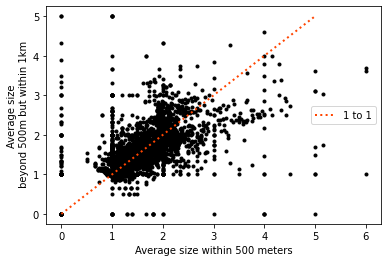

In [64]:
plt.scatter(average_within_500,
            average_500m_to_1k,
            color='k', marker='.')
plt.xlabel("Average size within 500 meters")
plt.ylabel("Average size\n beyond 500m but within 1km")
plt.plot([0,5],[0,5], color='orangered', linestyle=':', linewidth=2, 
         label='1 to 1')
plt.legend()

### Clustering as feature engineering

One unique way to use spatial or feature information *within* your data as a feature in your existing models is to use *clustering*, as we saw in Chapters 8 & 10. This can provide an indication of whether an observation exists in a given "place" geographically, or if an observation is a specific "kind" of observation. 

Sometimes, this data reduction of many correlated variates into a derived feature can be useful in training models. This is more useful when the *spatial location* of a given observation indicates something useful about what kind of observation is taken at that location. 

While it would be *best* to use an explicitly-spatial model to examine this structure, we can cheat a little bit and use cluster labels themselves as features. For example, to cluster the listings based on their location, we can use hierarchical DBSCAN, an improved variant of the DBSCAN algorithm used in chapter 8. 

In [65]:
from hdbscan import HDBSCAN

<frozen importlib._bootstrap>:219: RuntimeWarning: numpy.ufunc size changed, may indicate binary incompatibility. Expected 192 from C header, got 216 from PyObject


In [66]:
coordinates = numpy.column_stack((airbnbs_albers.geometry.x, 
                                  airbnbs_albers.geometry.y))

With a little tuning, we can decide on an effective parameterization. Here, we'll look for relatively large clusters of Airbnbs, those with about 100 listings or more. 

In [67]:
labels = HDBSCAN(min_cluster_size=25).fit(coordinates).labels_

The spatial distribution of these clusters gives us a sense of the geographical distribution of the observations. To help us visualize the clusters, we can construct the convex hull of the observations in each dectected cluster:

In [68]:
hulls = airbnbs_albers[['geometry']].dissolve(by=labels).convex_hull

Since humans tend to make locational decisions hierarchically (in that they pick *San Diego*, then they pick a particular *part* of San Diego (such as the Gaslamp Quarter), then they pick a house in that part), this clustering process might give us a reasonable insight into the enclaves of competition between Airbnbs:

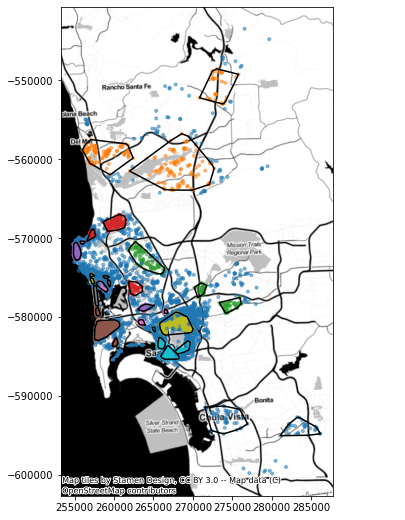

In [69]:
f, ax = plt.subplots(1, figsize=(9, 9))
airbnbs_albers.plot(column=labels,
                    categorical=True,
                    alpha=0.5,
                    legend=False,
                    ax=ax, marker='.'
                    )
hulls[hulls.index >=0].boundary.plot(color='k', ax=ax,)
contextily.add_basemap(ax, 
                       crs=airbnbs_albers.crs.to_string(), 
                       source=contextily.providers.Stamen.Toner
                      )

Regardless, this cluster label certainly communicates some information about the price of a listing, since the distributions of prices are substantially different across the detected clusters:

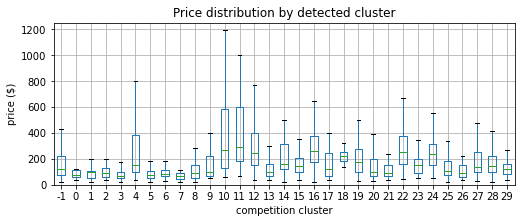

In [70]:
f = plt.figure(figsize=(8,3))
ax = airbnbs_albers.boxplot("price", by=labels, 
                            flierprops=dict(marker=None), 
                            ax=plt.gca())
ax.set_xlabel("competition cluster")
ax.set_ylabel("price ($)")
plt.gcf().suptitle(None)
ax.set_title("Price distribution by detected cluster")
ax.set_ylim(0,1250)
plt.show()

## Conclusion

Feature engineering is a powerful way to enrich your data analysis capabilities. It's often within reach of your existing data analysis methods: at a minimum, it only requires that new variables are constructed from your existing data. At a maximum, feature engineering gives you the *ultimate linkage key*, a flexible and powerful tool with which you can unlock the value held in many *other* datasets that you may have access to. 

The main operations and methods that are involved in feature engineering, such as determining what the average value is in the area near each observation or identifying whether observations exist in a "cluster," are fundamentally simple operations. Together, though, they build large, rich, and useful datasets that can be used directly in your existing methods of analysis. 

Beyond feature engineering, statistical techniques we discuss in this book (particularly in Chapters 10 and 11) can leverage spatial structure *directly* during learning. These techniques can best simpler less-complicated models that learn from spatially-engineered features. However, the techniques in this chatper (and the methods that extend upon them) are immediately useful for most practicing data scientists, and can be integrated into nearly any analytical method or approach. 

## Questions

1. Thinking of your own research, provide an example where map matching would
   be a useful spatial feature engineering approach? How about an example where
   map synthesis would be useful for your research?
2. In the  **Counting *nearby* features** example early in the chapter, there
   is a potential issue with under-counting the number of nearby bars and
   restaurants for certain Airbnbs in the dataset. Which Airbnbs are subject to
   neighbor under-counts and why?
3. How would you correct the under-count in the previous question?
4. Dasymetric mapping may introduce spurious spatial autocorrelation (see
   Chapters 6 and 7) through
   the interpolation process. How does this occur and why is it important to acknowledge?
